## Representation steering (Stable Diffusion v1.4)
This notebook reproduces **Figure 8**.

**Pipeline**:
1. Choose a steering task (e.g., `old` vs `young`, or `oil-painting` vs `photo`).
2. Build a steering vector from reference sets.
3. Apply the vector during sampling and compare outputs.


In [1]:
import os
from pathlib import Path
from types import MethodType

import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

from io_utils import read_jsonlines
from generate_utils import load_sd_pipe, generate_and_store
from rep_extraction_utils import extract_one

SAVE_DPI = 300
PLOT_RC = {
    "axes.titlesize": 28,
    "axes.labelsize": 24,
    "xtick.labelsize": 20,
    "ytick.labelsize": 20,
    "legend.fontsize": 24,
}



/home/zzekai/.conda/envs/playground/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1) Config (edit here)


In [2]:
# -------------------------
# Tunables (edit here)
# -------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_ID = "CompVis/stable-diffusion-v1-4"

SEED = 0

NUM_INFERENCE_STEPS = 40
GUIDANCE_SCALE = 7.5

CHECK_TIMESTEP = 10
POOLING = "spatial_mean"   # per-channel vector (recommended for steering)
USE_PROMPT = True          # use prompt embeddings when extracting reps

def set_random_seed(seed: int):
    seed = int(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_random_seed(SEED)

# -------------------------
# Steering layers (keep these)
# -------------------------
layer_weights = {
    "up_blocks.0.resnets.0": 1,
    "up_blocks.0.resnets.1": 1,
    "up_blocks.0.resnets.2": 1,
    "up_blocks.1.resnets.0": 1,
    "up_blocks.1.resnets.1": 1,
}
HOOK_NAMES = tuple(layer_weights.keys())

# -------------------------
# Steering schedule (stable + low artifacts)
# -------------------------
STEER_LAST_N = 20      # steer in the last N steps...
STEER_SKIP_LAST = 2    # ...except the last K steps

# Output dirs
SAMPLE_DIR = Path("samples/steering")
FIG_DIR = Path("../Figs")
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

# Reference set size (per side)
N_REF_PER_SIDE = 50
HEIGHT = 512
WIDTH = 512

# Steering strengths to visualize
ALPHAS = [0.0, 0.2, 0.3, 0.4, 0.5]


## 2) Load pipeline


In [3]:
pipe = load_sd_pipe(MODEL_ID, device=DEVICE)
print("[INFO] pipe.device:", pipe.device, "| unet dtype:", getattr(pipe.unet, "dtype", None))

Loading pipeline components...: 100%|██████████| 6/6 [00:01<00:00,  3.76it/s]


[INFO] pipe.device: cuda:0 | unet dtype: torch.float16


## 3) Build steering vectors from reference sets
We generate two small sets of images:
- **pos**: has the target attribute (e.g., `old`, `oil painting`)
- **neg**: the opposite / baseline (e.g., `young`, `photo`)

We take pooled activations at the target layer and compute a direction.


100%|██████████| 40/40 [00:01<00:00, 25.79it/s]
Writing JSON lines at samples/steering/ref_age_old_pos_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 188254.22it/s]
100%|██████████| 40/40 [00:01<00:00, 25.72it/s]
Writing JSON lines at samples/steering/ref_age_old_neg_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 214432.72it/s]


[INFO] pos jsonl: samples/steering/ref_age_old_pos_all.jsonl
[INFO] neg jsonl: samples/steering/ref_age_old_neg_all.jsonl


Reading JSON lines from samples/steering/ref_age_old_pos_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 291271.11lines/s]


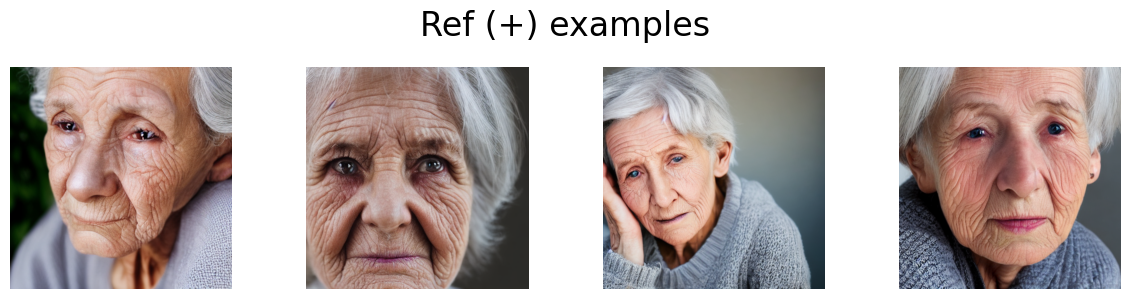

Reading JSON lines from samples/steering/ref_age_old_neg_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 294543.82lines/s]


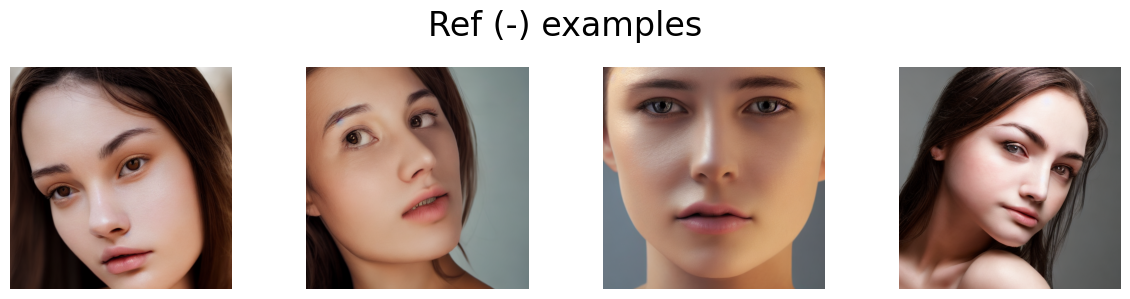

In [4]:
# --- Reference prompts (N_REF_PER_SIDE images via different initial noise) ---
STEER_TASK = "age_old"

REF_POS_PROMPT = (
    "A high-resolution front-facing portrait of an elderly woman, wrinkles, aged skin texture, "
    "gray hair, looking directly at the camera, natural lighting, highly detailed, realistic photography, 8k"
)
REF_NEG_PROMPT = (
    "A high-resolution front-facing portrait of a young woman, smooth skin, youthful features, "
    "looking directly at the camera, natural lighting, highly detailed, realistic photography, 8k"
)

RUN_POS = f"ref_{STEER_TASK}_pos"
RUN_NEG = f"ref_{STEER_TASK}_neg"

pos_jsonl = SAMPLE_DIR / f"{RUN_POS}_all.jsonl"
neg_jsonl = SAMPLE_DIR / f"{RUN_NEG}_all.jsonl"

def has_ref(jsonl_path: Path, n: int):
    if not jsonl_path.exists():
        return False
    rows = list(read_jsonlines(str(jsonl_path)))
    if len(rows) < n:
        return False
    for r in rows[:n]:
        if not Path(r["url"]).exists():
            return False
    return True

# generate
generate_and_store(
    pipe,
    [REF_POS_PROMPT] * N_REF_PER_SIDE,
    out_root=str(SAMPLE_DIR),
    run_name=RUN_POS,
    seed=SEED,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    height=HEIGHT,
    width=WIDTH,
    batch_size=1,
)
generate_and_store(
    pipe,
    [REF_NEG_PROMPT] * N_REF_PER_SIDE,
    out_root=str(SAMPLE_DIR),
    run_name=RUN_NEG,
    seed=SEED + 1000,
    num_inference_steps=NUM_INFERENCE_STEPS,
    guidance_scale=GUIDANCE_SCALE,
    height=HEIGHT,
    width=WIDTH,
    batch_size=1,
)

pos_jsonl = str(pos_jsonl)
neg_jsonl = str(neg_jsonl)
print("[INFO] pos jsonl:", pos_jsonl)
print("[INFO] neg jsonl:", neg_jsonl)

# quick sanity check
for jsonl_path, title in [(pos_jsonl, "Ref (+) examples"), (neg_jsonl, "Ref (-) examples")]:
    rows = list(read_jsonlines(jsonl_path))[:4]
    ims = [Image.open(r["url"]).convert("RGB") for r in rows]

    plt.figure(figsize=(3 * len(ims), 3))
    plt.suptitle(title, fontsize=24)
    for i, im in enumerate(ims):
        ax = plt.subplot(1, len(ims), i + 1)
        ax.imshow(im)
        ax.axis("off")
    plt.tight_layout()
    plt.show()


Reference sets are saved as PNGs plus a small `jsonl` manifest (`{url, prompt}`) for reproducibility.


In [ ]:
@torch.no_grad()
def collect_reps_from_jsonl(
    jsonl_path: str,
    *,
    hook_names=HOOK_NAMES,
    check_timestep=CHECK_TIMESTEP,
    pooling=POOLING,
    use_prompt=USE_PROMPT,
    image_size=512,
    max_n=None,
):
    """Return {layer: [N,C] CPU float tensors} for images listed in a jsonl manifest."""
    rows = list(read_jsonlines(jsonl_path))
    if max_n is not None:
        rows = rows[: int(max_n)]

    acc = {name: [] for name in hook_names}
    for r in rows:
        reps, _ = extract_one(
            pipe,
            image_path=r["url"],
            prompt=r.get("prompt", ""),
            check_timestep=int(check_timestep),
            hook_names=hook_names,
            pooling=pooling,
            use_prompt=bool(use_prompt),
            image_size=int(image_size),
            return_reps=True,
        )
        for name in hook_names:
            if name in reps:
                acc[name].append(reps[name])

    out = {}
    for name, vecs in acc.items():
        if len(vecs) > 0:
            out[name] = torch.stack(vecs, dim=0)  # [N,C], CPU float
    return out


# Extract both (+) and (-) reference reps (for visualization later).
pos_reps = collect_reps_from_jsonl(pos_jsonl, max_n=N_REF_PER_SIDE)
neg_reps = collect_reps_from_jsonl(neg_jsonl, max_n=N_REF_PER_SIDE)

# Steering vectors: ONLY by taking mean of the POS reps.
POS_MEAN = {name: pos_reps[name].mean(dim=0) for name in HOOK_NAMES}
NEG_MEAN = {name: neg_reps[name].mean(dim=0) for name in HOOK_NAMES}
V_BY_LAYER = {name: float(layer_weights[name]) * POS_MEAN[name] for name in HOOK_NAMES}

print("[INFO] built steering vectors from mean representations:", list(V_BY_LAYER.keys()))
for name, v in V_BY_LAYER.items():
    print(f" - {name}: |v|={v.norm().item():.3f} (scale={layer_weights[name]:.2g})")

Reading JSON lines from samples/steering/ref_age_old_pos_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 311612.48lines/s]
Reading JSON lines from samples/steering/ref_age_old_neg_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 270600.26lines/s]


[INFO] built steering vectors: ['up_blocks.0.resnets.0', 'up_blocks.0.resnets.1', 'up_blocks.0.resnets.2', 'up_blocks.1.resnets.0', 'up_blocks.1.resnets.1']
 - up_blocks.0.resnets.0: |v|=35.630 (scale=1)
 - up_blocks.0.resnets.1: |v|=33.326 (scale=1)
 - up_blocks.0.resnets.2: |v|=13.647 (scale=1)
 - up_blocks.1.resnets.0: |v|=34.201 (scale=1)
 - up_blocks.1.resnets.1: |v|=34.692 (scale=1)


## 4) Steering during sampling
We add `α · v` (broadcasted over spatial dims) to the chosen layer activations **near the end of sampling**:
- steer in the last `STEER_LAST_N` steps
- skip the final `STEER_SKIP_LAST_N` steps

Tune `α` to control strength.


In [6]:

class RepSteerer:
    """Add alpha * v to selected layer activations during sampling (training-free)."""

    def __init__(self, vec_by_layer, *, alpha, last_n, skip_last=0, cond_only=True):
        self.vec_by_layer = vec_by_layer  # {layer_name: [C] CPU tensor}
        self.alpha = alpha
        self.last_n = last_n
        self.skip_last = skip_last
        self.cond_only = cond_only

        self._handles = []
        self._orig_forward = None
        self._step = 0
        self._total_steps = None

    def _alpha_now(self):
        T = self._total_steps
        if T is None:
            return 0.0
        end = T - self.skip_last - 1
        start = max(0, end - self.last_n + 1)
        return self.alpha if (start <= self._step <= end) else 0.0

    def _steer(self, x, v, a):
        v = v.view(1, -1, 1, 1)
        # diffusers CFG: batch = [uncond; cond]
        if self.cond_only and x.shape[0] % 2 == 0:
            b = x.shape[0] // 2
            x = x.clone()
            x[b:] = x[b:] + a * v
            return x
        return x + a * v

    def _hook(self, name):
        def fn(_m, _inp, out):
            a = self._alpha_now()
            if a == 0.0 or name not in self.vec_by_layer:
                return out

            if isinstance(out, (tuple, list)):
                out0, rest = out[0], out[1:]
            else:
                out0, rest = out, None

            v = self.vec_by_layer[name].to(out0.device, out0.dtype)
            out0 = self._steer(out0, v, a)
            return out0 if rest is None else (out0, *rest)
        return fn

    def attach(self, unet, *, total_steps):
        self._total_steps = total_steps
        self._step = 0

        targets = set(self.vec_by_layer.keys())
        for name, module in unet.named_modules():
            if name in targets:
                self._handles.append(module.register_forward_hook(self._hook(name)))

        self._orig_forward = unet.forward

        def wrapped_forward(this, *args, **kwargs):
            out = self._orig_forward(*args, **kwargs)
            self._step += 1
            return out

        unet.forward = MethodType(wrapped_forward, unet)

    def detach(self, unet):
        for h in self._handles:
            h.remove()
        self._handles.clear()
        if self._orig_forward is not None:
            unet.forward = self._orig_forward
            self._orig_forward = None


@torch.no_grad()
def generate_with_steering(prompt, *, alpha, seed, cfg=None):
    cfg = GUIDANCE_SCALE if cfg is None else cfg
    g = torch.Generator(device=pipe.device).manual_seed(seed)

    steerer = RepSteerer(
        V_BY_LAYER,
        alpha=alpha,
        last_n=STEER_LAST_N,
        skip_last=STEER_SKIP_LAST,
        cond_only=(cfg > 1.0),
    )

    steerer.attach(pipe.unet, total_steps=NUM_INFERENCE_STEPS)
    out = pipe(
        prompt,
        num_inference_steps=NUM_INFERENCE_STEPS,
        guidance_scale=cfg,
        height=HEIGHT,
        width=WIDTH,
        generator=g,
    )
    steerer.detach(pipe.unet)
    return out.images[0]


## 5) Demo: steer a Gen sample vs a Mem sample
Replace these prompts if needed.


In [ ]:
# Gen. prompts
# PROMPT_GEN = "A high-resolution front-facing portrait of a man, looking directly at the camera, cinematic lighting, highly detailed skin texture, realistic photography, 8k",
# PROMPT_GEN = "A high-resolution front-facing portrait of a woman, looking directly at the camera, cinematic lighting, highly detailed skin texture, realistic photography, 8k",
# PROMPT_GEN = "Emma Watson",
# PROMPT_GEN = "An image of an lion, high quality, 8k",

# Mem. prompts
# PROMPT_MEM = "Living in the Light with Ann Graham Lotz",
# PROMPT_MEM = "Donna Tartt's <i>The Goldfinch</i> Scores Film Adaptation",
# PROMPT_MEM = "Emma Watson to play Belle in Disney's <i>Beauty and the Beast</i>",
# PROMPT_MEM = "Aaron Paul to Play Luke Skywalker at LACMA Reading of <i>The Empire Strikes Back",

100%|██████████| 40/40 [00:01<00:00, 25.13it/s]


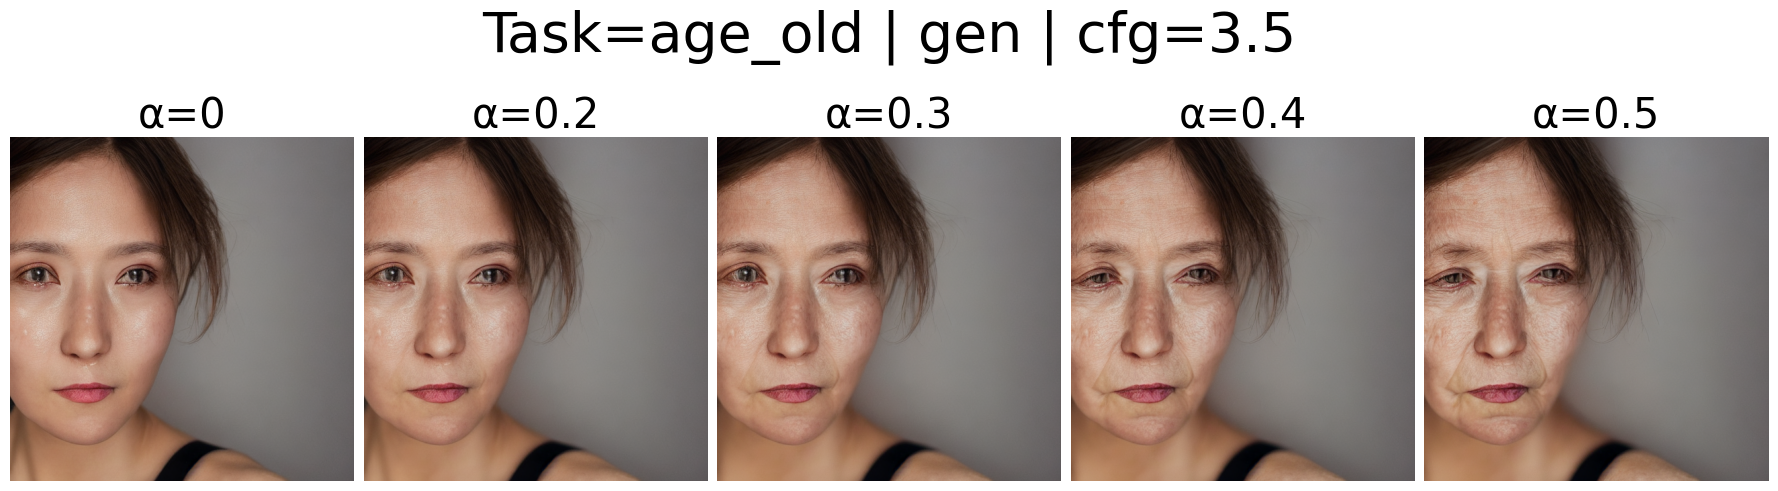

100%|██████████| 40/40 [00:01<00:00, 25.12it/s]


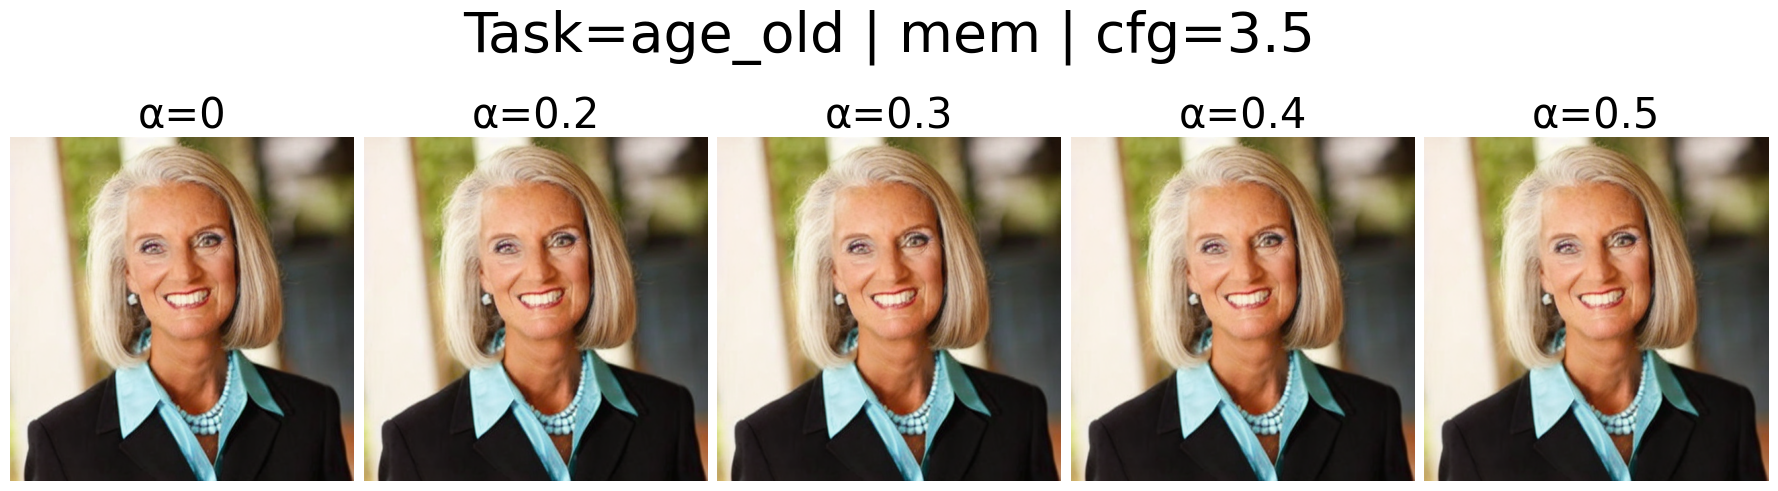

In [ ]:
PROMPT_GEN = "A high-resolution front-facing portrait of a woman, looking directly at the camera, cinematic lighting, highly detailed skin texture, realistic photography, 8k"
PROMPT_MEM = "Living in the Light with Ann Graham Lotz"

DEMO_CFG = 3.5  # slightly lower CFG for cleaner steering demo

cases = [
    ("gen", PROMPT_GEN, 2025, "laion_steering_gen.png"),
    ("mem", PROMPT_MEM, 100,  "laion_steering_mem.png"),
]

imgs_by_tag = {}

for tag, prompt, seed, out_name in cases:
    imgs = [generate_with_steering(prompt, alpha=a, seed=seed, cfg=DEMO_CFG) for a in ALPHAS]
    imgs_by_tag[tag] = imgs

    n = len(imgs)
    fig, axes = plt.subplots(1, n, figsize=(18, 4))
    axes = np.ravel(axes)

    fig.suptitle(f"Task={STEER_TASK} | {tag} | cfg={DEMO_CFG:g}", fontsize=40, y=1.2)

    for ax, im, a in zip(axes, imgs, ALPHAS):
        ax.imshow(im)
        ax.set_title(f"α={a:g}", fontsize=30, pad=2)
        ax.axis("off")
        
    fig.subplots_adjust(left=0.01, right=0.99, bottom=0.02, wspace=0.01)
    out_path = FIG_DIR / out_name
    fig.savefig(out_path, dpi=SAVE_DPI, bbox_inches="tight")
    plt.show()
    plt.close(fig)

imgs_gen = imgs_by_tag["gen"]
imgs_mem = imgs_by_tag["mem"]


Reading JSON lines from samples/steering/ref_age_old_pos_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 286105.32lines/s]
Reading JSON lines from samples/steering/ref_age_old_neg_all.jsonl: 100%|██████████| 50/50 [00:00<00:00, 336621.51lines/s]


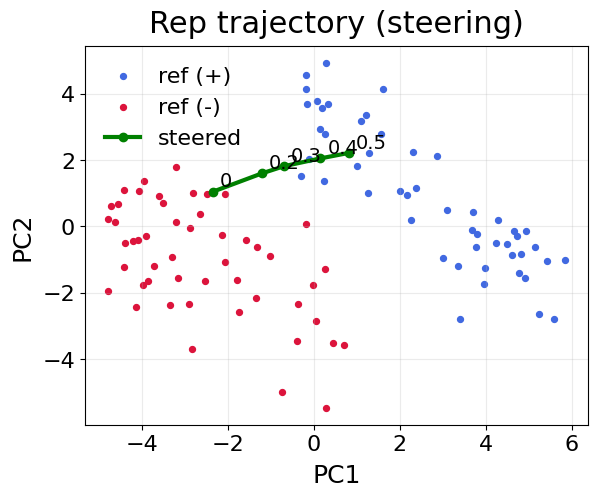

In [ ]:
# Optional: rep-space separation + steering trajectory(PCA-2D)
VIZ_LAYER = "up_blocks.0.resnets.1.norm1"

# refs
pos_X = collect_reps_from_jsonl(pos_jsonl, hook_names=(VIZ_LAYER,), max_n=N_REF_PER_SIDE, use_prompt=False)[VIZ_LAYER].numpy()
neg_X = collect_reps_from_jsonl(neg_jsonl, hook_names=(VIZ_LAYER,), max_n=N_REF_PER_SIDE, use_prompt=False)[VIZ_LAYER].numpy()

tmp_dir = SAMPLE_DIR / "tmp_traj"
tmp_dir.mkdir(parents=True, exist_ok=True)
gen_paths = []
for i, im in enumerate(imgs_gen):
    fp = tmp_dir / f"gen_{i:02d}.png"
    im.save(fp)
    gen_paths.append(fp)

gen_X = []
for p in gen_paths:
    reps, _ = extract_one(
        pipe,
        image_path=str(p),
        prompt="",
        check_timestep=int(CHECK_TIMESTEP),
        hook_names=(VIZ_LAYER,),
        pooling="spatial_mean",
        use_prompt=False,
        image_size=int(HEIGHT),
        return_reps=True,
    )
    gen_X.append(reps[VIZ_LAYER].numpy())
gen_X = np.stack(gen_X, axis=0)

# PCA on (pos, neg, gen) jointly
X_all = np.concatenate([pos_X, neg_X, gen_X], axis=0).astype(np.float32)
Xc = X_all - X_all.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd(Xc, full_matrices=False)
Z = Xc @ Vt[:2].T

npos, nneg, ngen = len(pos_X), len(neg_X), len(gen_X)
Z_pos, Z_neg, Z_gen = Z[:npos], Z[npos:npos+nneg], Z[npos+nneg:npos+nneg+ngen]

# plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.scatter(Z_pos[:, 0], Z_pos[:, 1], s=18, c="royalblue", label="ref (+)")
ax.scatter(Z_neg[:, 0], Z_neg[:, 1], s=18, c="crimson", label="ref (-)")
ax.plot(Z_gen[:, 0], Z_gen[:, 1], "-o", lw=3, c="green", zorder=5, label="steered")

for i in range(len(Z_gen) - 1):
    ax.annotate(
        "",
        xy=(Z_gen[i + 1, 0], Z_gen[i + 1, 1]),
        xytext=(Z_gen[i, 0], Z_gen[i, 1]),
        zorder=6,
    )

dx = 0.015 * (Z[:, 0].max() - Z[:, 0].min() + 1e-9)
dy = 0.015 * (Z[:, 1].max() - Z[:, 1].min() + 1e-9)
for i, a in enumerate(ALPHAS):
    ax.text(Z_gen[i, 0] + dx, Z_gen[i, 1] + dy, f"{a:g}", fontsize=14, color="k", zorder=8)

ax.set_title("Rep trajectory (steering)", fontsize=22, pad=10)
ax.set_xlabel("PC1", fontsize=18, labelpad=6)
ax.set_ylabel("PC2", fontsize=18, labelpad=6)
ax.tick_params(axis="both", which="major", labelsize=16)
ax.grid(True, alpha=0.25, linewidth=0.8)

ax.legend(frameon=False, loc="best", fontsize=16, handlelength=1.6)
fig.tight_layout(pad=0.8)
out_path = FIG_DIR / 'laion_rep_traj.png'
fig.savefig(out_path, dpi=300)
plt.show()